In [2]:
# 前置环境
using Glob  # find files with a specific pattern
using DelimitedFiles, DataFrames, EzXML #read txt  and xml and then convert them to DataFrames
using Dates
using LaTeXStrings
#using ContinuousWavelets  #wavelet power
using Interpolations # interpolation
#using StaticArrays #faster array
#using VMD # VMD decomposition
using DSP
using LinearAlgebra
include("./scripts/TCWavelet.jl")


const Rm = 3390.0 #km
#Edberg, N. J. T., M. Lester, S. W. H. Cowley, and A. I. Eriksson (2008), Statistical analysis of the location of the Martian magnetic pileup boundary and bow shock and the influence of crustal magnetic fields, J. Geophys. Res., 113, A08206, doi:10.1029/2008JA013096.
#bow-shock model
function bowshock(xshock)
    xF = 0.55 # Rm
    ϵ = 1.05
    L = 2.10 # rm
    rSD = 1.58
    temp = (ϵ^2-1.0)*(xshock-xF)^2-2ϵ*L*(xshock-xF)+L^2
    if temp>=0 
        return sqrt(temp)
    else
        return Inf64
    end
end
#magnetopause model
function magnetopause(xmp)
    rSD = 1.33
	xF = 0.86
	ϵ = 0.92
	L = 0.90
    temp = (ϵ^2-1.0)*(xmp-xF)^2-2ϵ*L*(xmp-xF)+L^2
    if temp>=0 
        return sqrt(temp)
    else
        return Inf64
    end
end

np = 5001
xshock = range(-10, 3, length=np)
ryzshock = bowshock.(xshock)
ind = findall(isfinite, ryzshock)
xshock = [xshock[ind]; reverse(xshock[ind])]
ryzshock = [ryzshock[ind]; -reverse(ryzshock[ind])]
xmp = range(-10, 3, length=np)
ryzmp = magnetopause.(xmp)
ind = findall(isfinite, ryzmp)
xmp = [xmp[ind]; reverse(xmp[ind])]
ryzmp = [ryzmp[ind]; -reverse(ryzmp[ind])]

print("Done")

Done

In [77]:
date = DateTime(2022, 08, 24, 07, 30, 18)
shock_time = DateTime(2022, 08, 24, 07, 27, 00)
ds = 1

1

In [33]:
# read data 
datapath2c32hz = "E:/WorkSpace/Tianwen/Data/MAVEN/"
date = DateTime(2022, 08, 24, 00, 00, 00)
#date = DateTime(2014, 10, 11, 00, 00, 00) .+ Dates.Day(1) .* range(0, 1)
#20220630
datestr = Dates.format.(date, "yyyymmdd")
year = Dates.format(date, "yyyy")
file2c32hz = glob("*$datestr*.sts", datapath2c32hz)
# println(file2c32hz)
file2c32hz=file2c32hz[1]
skip = 1 
println("Reading file: ")
println(file2c32hz)
for line in eachline(file2c32hz)
    if line[1:6] != "  $year"
        skip = skip+1
    else
        break
    end
end
global mag2c32hz = identity.(DataFrame(readdlm(file2c32hz, skipstart=skip), :auto))

global BMSO32hz = Array(mag2c32hz[:, 8:10])
global  magut32hz = @. DateTime(mag2c32hz[:, 1]) + Day(mag2c32hz[:, 2]-1) + Hour(mag2c32hz[:, 3]) + Minute(mag2c32hz[:, 4]) + Second(mag2c32hz[:, 5]) + Millisecond(mag2c32hz[:, 6])
global  magjlut32hz = datetime2julian.(magut32hz)
magjlut32hz= magjlut32hz.-magjlut32hz[1]
global  PosMSO32hz = Array(mag2c32hz[:, 12:14])./Rm
mag2c32hz[!, :Time] = magut32hz
mag2c32hz[!, :JulUT] = magjlut32hz
mag2c32hz.X_MSO = BMSO32hz[:, 1]
mag2c32hz.Y_MSO = BMSO32hz[:, 2]
mag2c32hz.Z_MSO = BMSO32hz[:, 3]
mag2c32hz.Probe_Position_X_MSO = PosMSO32hz[:, 1]
mag2c32hz.Probe_Position_Y_MSO = PosMSO32hz[:, 2]
mag2c32hz.Probe_Position_Z_MSO = PosMSO32hz[:, 3]
println("Data read finished!")

Reading file: 
E:/WorkSpace/Tianwen/Data/MAVEN/mvn_mag_l2_2022236ss_20220824_v01_r01.sts
Data read finished!


In [122]:
first(mag2c32hz, 5)

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,Time,JulUT,X_MSO,Y_MSO,Z_MSO,Probe_Position_X_MSO,Probe_Position_Y_MSO,Probe_Position_Z_MSO
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2022.0,236.0,0.0,0.0,1.0,136.0,236.0,6.42,-1.29,-6.22,0.0,2303.3,-1533.47,5824.94,0.0,-0.189,0.519,0.0,2022-08-24T00:00:01.136,0.0,6.42,-1.29,-6.22,0.67944,-0.452351,1.71827
2,2022.0,236.0,0.0,0.0,1.0,168.0,236.0,5.76,-1.89,-6.76,0.0,2303.38,-1533.48,5824.94,0.0,-0.189,0.519,0.0,2022-08-24T00:00:01.168,3.70666e-7,5.76,-1.89,-6.76,0.679462,-0.452355,1.71827
3,2022.0,236.0,0.0,0.0,1.0,199.0,236.0,5.47,-3.04,-7.13,0.0,2303.45,-1533.49,5824.94,0.0,-0.189,0.519,0.0,2022-08-24T00:00:01.199,7.29226e-7,5.47,-3.04,-7.13,0.679484,-0.452358,1.71827
4,2022.0,236.0,0.0,0.0,1.0,230.0,236.0,5.86,-4.48,-6.32,0.0,2303.53,-1533.51,5824.93,0.0,-0.189,0.519,0.0,2022-08-24T00:00:01.230,1.08825e-6,5.86,-4.48,-6.32,0.679506,-0.452361,1.71827
5,2022.0,236.0,0.0,0.0,1.0,261.0,236.0,5.61,-5.16,-4.92,0.0,2303.6,-1533.52,5824.93,0.0,-0.189,0.519,0.0,2022-08-24T00:00:01.261,1.44681e-6,5.61,-5.16,-4.92,0.679528,-0.452365,1.71827


In [94]:
# 分离背景磁场和波动磁场
timeWave = date .+ Dates.Second(ds) .* range(0,4)
timeShock = shock_time - Dates.Minute(1) .+ Dates.Minute(1) .* range(0, 2)
timeSolar = shock_time .- Dates.Minute(1) .* range(0,5)
indWave = findall(
(minimum(timeWave) .<= mag2c32hz.Time .<= maximum(timeWave)) .&
.!isnan.(mag2c32hz.X_MSO) .&
.!isnan.(mag2c32hz.Y_MSO) .&
.!isnan.(mag2c32hz.Z_MSO)
)
intShock = findall(
(minimum(timeShock) .<= mag2c32hz.Time .<= maximum(timeShock)) .&
.!isnan.(mag2c32hz.X_MSO) .&
.!isnan.(mag2c32hz.Y_MSO) .&
.!isnan.(mag2c32hz.Z_MSO)
)
intSolar = findall(
(minimum(timeSolar) .<= mag2c32hz.Time .<= maximum(timeSolar)) .&
.!isnan.(mag2c32hz.X_MSO) .&
.!isnan.(mag2c32hz.Y_MSO) .&
.!isnan.(mag2c32hz.Z_MSO)
)
magWave = mag2c32hz[indWave, [:X_MSO, :Y_MSO, :Z_MSO]]
magShock = mag2c32hz[intShock, [:X_MSO, :Y_MSO, :Z_MSO]]
magSolar = mag2c32hz[intSolar, [:X_MSO, :Y_MSO, :Z_MSO]]
magWaveMean = zeros(1, 3)
magSolarMean = zeros(1, 3)
for i in 1:3
    magWaveMean[1, i] = mean(magWave[:, i])
    magSolarMean[1, i] = mean(magSolar[:, i])
end
magWave = magWave .- magWaveMean
ReB = mag2c32hz[indWave, [:X_MSO, :Y_MSO, :Z_MSO]]
ReB[:, :MSO] = sqrt.(ReB[:, 1].^2 .+ ReB[:, 2].^2 .+ ReB[:, 3].^2)
println("Background field separation finished!")

Background field separation finished!


In [87]:
# 波动性质和激波性质
function MVA(magbc)
    nb = length(magbc[:, 1])
    bm = mean(magbc, dims=1)
    muv = magbc' * magbc ./ nb - bm' * bm
    return eigen(muv)
end

function angle_between(v1, v2)
    cosθ = dot(v1, v2) / (norm(v1) * norm(v2))
    return acosd(clamp(cosθ, -1.0, 1.0))  # 限制范围防止数值误差
end

# 波动性质
bWave = Array(magWave)
Bmean = Array(magWaveMean)
bm = MVA(bWave)
# 波矢量WaveNormal
kWave = bm.vectors[:, argmin(bm.values)]
Bmva = bWave*bm.vectors
Bmvamean= dropdims(mean(Bmva, dims=1), dims=1)
# 振幅Amplitude
Amplitude = sum(bm.values[1:3])

# 激波性质
bShock = Array(magShock[:, 1:3])
BmeanShock = dropdims(mean(bShock, dims=1), dims=1)
bmShock = MVA(bShock)
# 激波法向ShockNormal
kShock = bmShock.vectors[:, 1]

# 太阳风性质
bSolar = Array(magSolar[:, 1:3])
BmeanSolar = dropdims(mean(bSolar, dims=1), dims=1)
bmSolar = MVA(bSolar)
kSolar = bmSolar.vectors[:, 1]

# 传播角PropagationAngle
ProAngle = angle_between(kWave, magWaveMean)
ShockAngle = angle_between(magSolarMean, kShock)
# ShockAngle = angle_between(kSolar, kShock)
if ShockAngle>90
    ShockAngle = 180 -ShockAngle
end

magback = sqrt(sum(Bmean.^2))
maxAm = maximum([maximum(bWave[:,1])-minimum(bWave[:,1]), maximum(bWave[:,2])-minimum(bWave[:,2]), 
    maximum(bWave[:,3])-minimum(bWave[:,3])])

println("Amplitude: ", Amplitude)
println("Propagation Angle: ", ProAngle)
println("Shock Angle: ", ShockAngle)
println("Magnetic Background: ", magback)

Amplitude: 0.22489467163085938
Propagation Angle: 35.77178919759409
Shock Angle: 49.87368392278276
Magnetic Background: 3.161093291429271


In [100]:
mag2c32hz[1, :JulUT]

0.0

In [110]:
xtk = datetime2julian.(timeWave)


5-element Vector{Float64}:
 2.459815812708333e6
 2.4598158127199076e6
 2.4598158127314816e6
 2.4598158127430556e6
 2.4598158127546296e6

In [102]:
bWaveMVA

128×3 Matrix{Float64}:
 -0.0144479    0.0398852    0.0604306
 -0.122858    -0.0578184   -0.14255
 -0.121735    -0.141945    -0.0987154
 -0.149413    -0.143213    -6.30955e-5
 -0.12654     -0.0678686    0.00022721
 -0.158578    -0.140155    -0.071524
 -0.213436    -0.117338     0.0512357
 -0.266536    -0.173996    -0.0059508
 -0.191312    -0.11485      0.0736934
 -0.125417    -0.151995     0.0440621
 -0.186843    -0.114932     0.0871104
 -0.205919    -0.11202      0.145656
 -0.106512     0.0184364    0.135691
  ⋮                        
  0.343849     0.0943912    0.0531961
  0.305745     0.131357     0.0064885
  0.184876     0.123114    -0.0427342
  0.0665174    0.177904    -0.11477
 -0.0434007    0.207179    -0.0854275
 -0.0830659    0.200674    -0.0946126
 -0.0894339    0.161628    -0.137448
 -0.263564     0.0670318   -0.102371
 -0.215933     0.00341178  -0.0888117
 -0.178578    -0.10641     -0.0199367
 -0.0644772   -0.0306284   -0.087302
 -0.00715804  -0.0215549   -0.0690761

In [113]:
minimum(xtk)

2.459815812708333e6

Drawing...


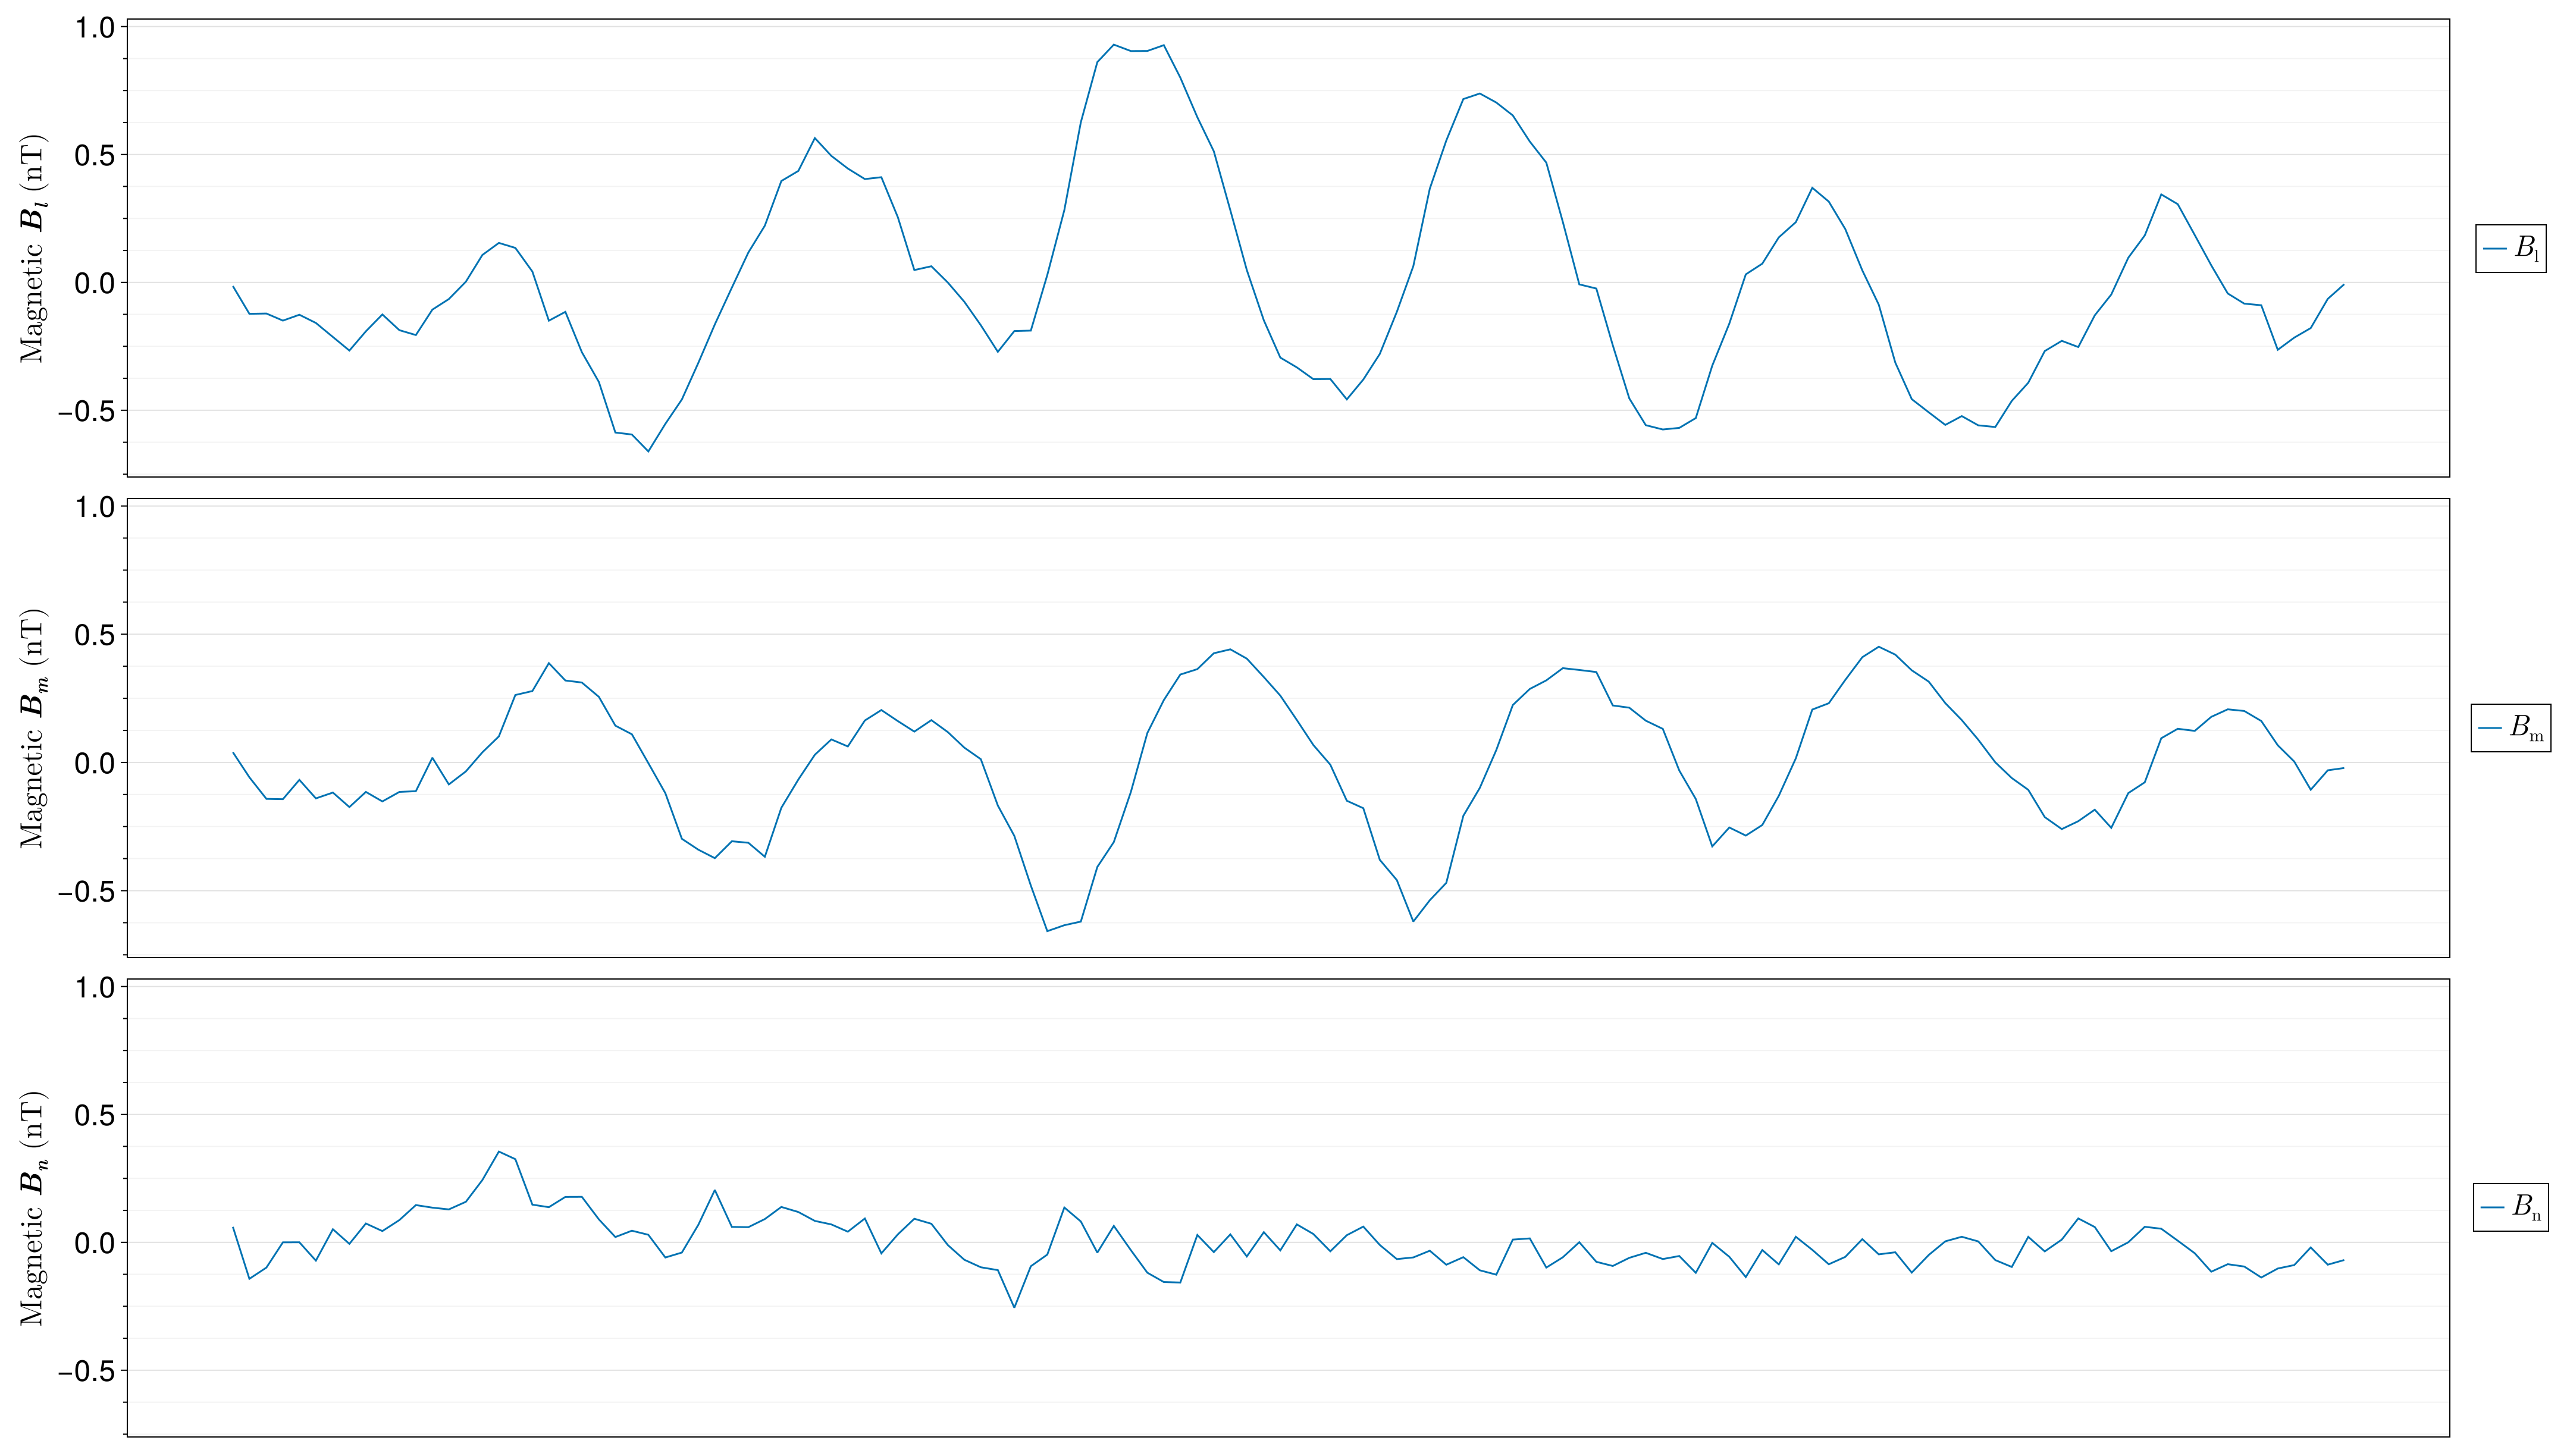

CairoMakie.Screen{IMAGE}


In [120]:
# MVA坐标系
bm = MVA(bWave)
n_hat = bm.vectors[:, 1]
m_hat = bm.vectors[:, 2]
l_hat = bm.vectors[:, 3]
R = R = [l_hat m_hat n_hat]

bWaveMVA = bWave * R

#overview
using CairoMakie, GeometryBasics
CairoMakie.activate!()
println("Drawing...")

size_inches = (30, 17)
size_pt = 72 .* size_inches
fig_MVA = Figure(size = size_pt, fontsize = 25, font = "Times New Roman")

xtk = datetime2julian.(timeWave)
xtk = Float64.(xtk .- mag2c32hz[indWave[1], :JulUT])

ax1 = Axis(fig_MVA[1,1:4], ylabel = L"Magnetic $\mathbf{B_l}$ (nT)",
    xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(5), 
    yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(4))
ax1.xticks = (xtk, Dates.format.(timeWave, "HH:MM:SS"))
#xlims!(ax1, minimum(xtk), maximum(xtk))
ylims!(ax1, minimum(bWaveMVA[:, 1:3])-0.1, maximum(bWaveMVA[:, 1:3])+0.1)

ax2 = Axis(fig_MVA[2,1:4], ylabel = L"Magnetic $\mathbf{B_m}$ (nT)",
    xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(5), 
    yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(4))
ax2.xticks = (xtk, Dates.format.(timeWave, "HH:MM:SS"))
#xlims!(ax2, minimum(xtk), maximum(xtk))
ylims!(ax2, minimum(bWaveMVA[:, 1:3])-0.1, maximum(bWaveMVA[:, 1:3])+0.1)

ax3 = Axis(fig_MVA[3,1:4], ylabel = L"Magnetic $\mathbf{B_n}$ (nT)",
    xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(5), 
    yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(4))
ax3.xticks = (xtk, Dates.format.(timeWave, "HH:MM:SS"))
#xlims!(ax3, minimum(xtk), maximum(xtk))
ylims!(ax3, minimum(bWaveMVA[:, 1:3])-0.1, maximum(bWaveMVA[:, 1:3])+0.1)

plot_x = Float64.(mag2c32hz[indWave, :JulUT] .- mag2c32hz[indWave[1], :JulUT])

lines!(ax1, plot_x, bWaveMVA[:, 1], label = L"$B_{\mathrm{l}}$", 
    overdraw = true, linewidth=1.5)
lines!(ax2, plot_x, bWaveMVA[:, 2], label = L"$B_{\mathrm{m}}$", 
    overdraw = true, linewidth=1.5)
lines!(ax3, plot_x, bWaveMVA[:, 3], label = L"$B_{\mathrm{n}}$", 
    overdraw = true, linewidth=1.5)
Legend(fig_MVA[1,5], ax1)
Legend(fig_MVA[2,5], ax2)
Legend(fig_MVA[3,5], ax3)

display(fig_MVA)

In [121]:
save(".MVA_overview_wave_MAVEN.png", fig_MVA)

In [31]:
#wavelet power
ns32hz = size(ReB)[1]
# dt32hz = 1.0/32.0
dt32hz = 1.0

println("Wavelet power calculation...")
mother = "MORLET"
wave32hz, period32hz, scale32hz, coi32hz = wavelet(reshape(ReB[:, 1], ns32hz), dt32hz; pad=1, mother=mother)
xpower32hz = abs.(wave32hz).^2
wave32hz, period32hz, scale32hz, coi32hz = wavelet(reshape(ReB[:, 2], ns32hz), dt32hz; pad=1, mother=mother)
ypower32hz = abs.(wave32hz).^2
wave32hz, period32hz, scale32hz, coi32hz = wavelet(reshape(ReB[:, 3], ns32hz), dt32hz; pad=1, mother=mother)
zpower32hz = abs.(wave32hz).^2
Bpower32hz =xpower32hz+ypower32hz+zpower32hz
println("Wavelet power calculation finished!")

Wavelet power calculation...
Wavelet power calculation finished!


In [35]:
# 画轨道、波形和功率谱图4

"bow-shock model"
function bowshock(xshock)
    xF = 0.55 # Rm
    ϵ = 1.05
    L = 2.10 # rm
    rSD = 1.58
    temp = (ϵ^2-1.0)*(xshock-xF)^2-2ϵ*L*(xshock-xF)+L^2
    if temp>=0 
        return sqrt(temp)
    else
        return Inf64
    end
end
"magnetopause model"
function magnetopause(xmp)
    rSD = 1.33
	xF = 0.86
	ϵ = 0.92
	L = 0.90
    temp = (ϵ^2-1.0)*(xmp-xF)^2-2ϵ*L*(xmp-xF)+L^2
    if temp>=0 
        return sqrt(temp)
    else
        return Inf64
    end
end

np = 5001
xshock = range(-10, 3, length=np)
ryzshock = bowshock.(xshock)
ind1 = findall(isfinite, ryzshock)
xshock = [xshock[ind1]; reverse(xshock[ind1])]
ryzshock = [ryzshock[ind1]; -reverse(ryzshock[ind1])]
xmp = range(-10, 3, length=np)
ryzmp = magnetopause.(xmp)
ind1 = findall(isfinite, ryzmp)
xmp = [xmp[ind1]; reverse(xmp[ind1])]
ryzmp = [ryzmp[ind1]; -reverse(ryzmp[ind1])]


#overview
using CairoMakie, GeometryBasics
CairoMakie.activate!()
println("Drawing...")
# light_latexfonts = merge(theme_minimal(), theme_latexfonts())
# set_theme!(light_latexfonts)

size_inches = (30, 17)
size_pt = 72 .* size_inches
fig = Figure(size = size_pt, fontsize = 25, font = "Times New Roman")
#fig = Figure(resolution = (1200, 800), font = "Times New Roman", fontsize = 20)
xtk = datetime2julian.(timeWave)
xtk = Float32.(xtk .- mag2c32hz[1, :JulUT])

titles = Dates.format.(date, "yyyy-mm-dd") * " " * Dates.format.(timeWave[1], "HH:MM:SS") * "-" * 
    Dates.format.(timeWave[end], "HH:MM:SS") * "    " * "Martian 1Hz Waves"

ax3 = Axis(fig[1,1], aspect=DataAspect(), xlabel=L"$x$ ($R_{\mathrm{M}}$)", 
    ylabel=L"$\sqrt{y^2+z^2}$ ($R_{\mathrm{M}}$)", xticks=range(-10, 10), yticks=range(-10, 10))
xlims!(ax3, 5, -5) 
ylims!(ax3, 0, 5) 
a1 = arc!(ax3, Point2f(0), 1, 0, π; color=:black, linewidth=2)
phi = range(0, 0.5π; length=180)
x = [cos.(phi); 0.0]
y = [sin.(phi); 0.0]
pn = Polygon(Point2f[(xi, yi) for (xi, yi) in zip(x, y)])
poly!(ax3, pn)

l1 = lines!(ax3, xshock, ryzshock; linewidth=2, overdraw = true)
l2 = lines!(ax3, xmp, ryzmp; linewidth=2, overdraw = true)
l3 = lines!(ax3, mag2c32hz[!, :Probe_Position_X_MSO], 
    sqrt.(mag2c32hz[!, :Probe_Position_Y_MSO].^2+mag2c32hz[!, :Probe_Position_Z_MSO].^2); 
    color=:black, overdraw = true)

indd = findall(x-> x<timeWave[1] + Dates.Second(1)  && x>timeWave[1] - Dates.Second(1), mag2c32hz[!, :Time]) 
str = Dates.format(date, "HH:MM:SS")
scatter!(ax3, mag2c32hz[indd, :Probe_Position_X_MSO], 
    sqrt.(mag2c32hz[indd, :Probe_Position_Y_MSO].^2+mag2c32hz[indd, :Probe_Position_Z_MSO].^2), 
    markersize=20, label=str, color=1, colorrange=(1, 7), colormap=:tab10)
text!(ax3, 0.85, 0.9-0.1, text = str, font = :bold, align = (:center, :center), 
    space = :relative, fontsize = 25, color=1, colorrange=(1, 7), colormap=:tab10)

ax = Axis(fig[1,2:4], ylabel = L"Magnetic $\mathbf{B}$ (nT)", title=titles, 
    xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(5), 
    yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(4))
ax.xticks = (xtk, Dates.format.(timeWave, "HH:MM:SS"))
xlims!(ax, minimum(xtk), maximum(xtk))
ylims!(ax, minimum(ReB[!, 4])-1.0, maximum(ReB[!, 4])+1.0)

lines!(ax, mag2c32hz[ind, :JulUT].-mag2c32hz[1, :JulUT], ReB[!, :MSO], label = L"$B_{\mathrm{sum}}$", 
    overdraw = true, linewidth=1.5, color = :black)
Legend(fig[1,5], ax)

ax1 = Axis(fig[2,1:4], ylabel = L"Magnetic $\mathbf{B}$ (nT)",
    xminorticksvisible = true, xminorgridvisible = true, xminorticks = IntervalsBetween(5), 
    yminorticksvisible = true, yminorgridvisible = true, yminorticks = IntervalsBetween(4))
ax1.xticks = (xtk, Dates.format.(timeWave, "HH:MM:SS"))
xlims!(ax1, minimum(xtk), maximum(xtk))
ylims!(ax1, minimum(Matrix(ReB[!, 1:3]))-1.0, maximum(Matrix(ReB[!, 1:3]))+1.0)

lines!(ax1, mag2c32hz[ind, :JulUT].-mag2c32hz[1, :JulUT], ReB[!, :X_MSO], label = L"$B_{\mathrm{x}}$", 
    overdraw = true, linewidth=1.5)
lines!(ax1, mag2c32hz[ind, :JulUT].-mag2c32hz[1, :JulUT], ReB[!, :Y_MSO], label = L"$B_{\mathrm{y}}$", 
    overdraw = true, linewidth=1.5)
lines!(ax1, mag2c32hz[ind, :JulUT].-mag2c32hz[1, :JulUT], ReB[!, :Z_MSO], label = L"$B_{\mathrm{z}}$", 
    overdraw = true, linewidth=1.5)
Legend(fig[2,5], ax1)

ax2 = Axis(fig[3,1:4], xlabel = L"Time(HH:MM:SS)", ylabel = L"Period $T$ (s)",xticks=xtk, yscale=log2)
ax2.xticks = (xtk, Dates.format.(timeWave, "HH:MM:SS"))
xlims!(ax2, minimum(xtk), maximum(xtk))
# ylims!(ax2, 1.0/16.0, 128)
ylims!(ax2, 1.0, 16)
ax2.yreversed = true
hp1 = heatmap!(ax2, magut32hz[ind], period32hz, Bpower32hz', 
    colorscale=log10, colormap=:gist_earth, colorrange=(2e-4, 3e2))
tightlimits!(ax2)
cb = Colorbar(fig[3, 5], hp1, label = L"Wavelet Power $P_{\mathrm{B}}$")

println("Drawing finished!")
save("./" * Dates.format(timeWave[1], "yyyymmdd HH-MM-SS") * "-MAVEN-OWWP.png", fig)

Drawing...


LoadError: Can't set x limits to the same value 2.4598155e6.

In [ ]:
magut32hz

2764799-element Vector{DateTime}:
 2022-08-24T00:00:01.136
 2022-08-24T00:00:01.168
 2022-08-24T00:00:01.199
 2022-08-24T00:00:01.230
 2022-08-24T00:00:01.261
 2022-08-24T00:00:01.293
 2022-08-24T00:00:01.324
 2022-08-24T00:00:01.355
 2022-08-24T00:00:01.386
 2022-08-24T00:00:01.418
 2022-08-24T00:00:01.449
 2022-08-24T00:00:01.480
 2022-08-24T00:00:01.511
 ⋮
 2022-08-25T00:00:00.258
 2022-08-25T00:00:00.289
 2022-08-25T00:00:00.320
 2022-08-25T00:00:00.352
 2022-08-25T00:00:00.383
 2022-08-25T00:00:00.414
 2022-08-25T00:00:00.445
 2022-08-25T00:00:00.477
 2022-08-25T00:00:00.508
 2022-08-25T00:00:00.539
 2022-08-25T00:00:00.570
 2022-08-25T00:00:00.602

In [13]:
PosMSO32hz

2764799×3 Matrix{Float64}:
 0.67944   -0.452351    1.71827
 0.679462  -0.452355    1.71827
 0.679484  -0.452358    1.71827
 0.679506  -0.452361    1.71827
 0.679528  -0.452365    1.71827
 0.67955   -0.452368    1.71827
 0.679572  -0.452371    1.71827
 0.679594  -0.452375    1.71827
 0.679616  -0.452378    1.71826
 0.679638  -0.452381    1.71826
 0.67966   -0.452385    1.71826
 0.679682  -0.452388    1.71826
 0.679704  -0.452391    1.71826
 ⋮                     
 1.19994    0.0396729  -1.25174
 1.19992    0.0396788  -1.25175
 1.1999     0.0396847  -1.25176
 1.19988    0.0396906  -1.25176
 1.19986    0.0396962  -1.25177
 1.19983    0.0397021  -1.25178
 1.19981    0.039708   -1.25179
 1.19979    0.0397139  -1.2518
 1.19977    0.0397195  -1.25181
 1.19974    0.0397254  -1.25182
 1.19972    0.0397313  -1.25182
 1.1997     0.0397372  -1.25183

In [14]:
BMSO32hz

2764799×3 Matrix{Float64}:
  6.42  -1.29  -6.22
  5.76  -1.89  -6.76
  5.47  -3.04  -7.13
  5.86  -4.48  -6.32
  5.61  -5.16  -4.92
  3.88  -5.33  -4.35
  2.72  -6.08  -3.17
  1.82  -6.48  -3.1
  1.55  -6.9   -3.27
  1.8   -6.89  -2.93
  2.16  -8.41  -2.97
  2.24  -9.35  -2.09
  1.9   -8.55  -1.25
  ⋮            
 -5.59  -3.9   -8.39
 -5.74  -4.07  -8.2
 -5.63  -4.48  -8.35
 -5.33  -4.98  -8.11
 -5.19  -5.06  -8.02
 -5.02  -4.95  -7.63
 -4.56  -4.44  -7.38
 -4.22  -3.75  -7.12
 -3.29  -3.95  -6.26
 -2.5   -3.67  -4.15
 -2.39  -2.53  -2.7
 -3.18  -3.0   -3.52

In [ ]:
mag2c32hz

Row,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2022.0,236.0,0.0,0.0,1.0,136.0,236.0,6.42,-1.29,-6.22,0.0,2303.3,-1533.47,5824.94,0.0,-0.189,0.519,0.0
2,2022.0,236.0,0.0,0.0,1.0,168.0,236.0,5.76,-1.89,-6.76,0.0,2303.38,-1533.48,5824.94,0.0,-0.189,0.519,0.0
3,2022.0,236.0,0.0,0.0,1.0,199.0,236.0,5.47,-3.04,-7.13,0.0,2303.45,-1533.49,5824.94,0.0,-0.189,0.519,0.0
4,2022.0,236.0,0.0,0.0,1.0,230.0,236.0,5.86,-4.48,-6.32,0.0,2303.53,-1533.51,5824.93,0.0,-0.189,0.519,0.0
5,2022.0,236.0,0.0,0.0,1.0,261.0,236.0,5.61,-5.16,-4.92,0.0,2303.6,-1533.52,5824.93,0.0,-0.189,0.519,0.0
6,2022.0,236.0,0.0,0.0,1.0,293.0,236.0,3.88,-5.33,-4.35,0.0,2303.67,-1533.53,5824.93,0.0,-0.189,0.519,0.0
7,2022.0,236.0,0.0,0.0,1.0,324.0,236.0,2.72,-6.08,-3.17,0.0,2303.75,-1533.54,5824.92,0.0,-0.189,0.519,0.0
8,2022.0,236.0,0.0,0.0,1.0,355.0,236.0,1.82,-6.48,-3.1,0.0,2303.82,-1533.55,5824.92,0.0,-0.189,0.519,0.0
9,2022.0,236.0,0.0,0.0,1.0,386.0,236.0,1.55,-6.9,-3.27,0.0,2303.9,-1533.56,5824.92,0.0,-0.189,0.519,0.0


In [ ]:
# 分离背景磁场和波动磁场
timeWave = date .+ Dates.Second(ds) .* range(0,6)
timeShock = shock_time - Dates.Minute(1) .+ Dates.Minute(1) .* range(0, 2)
timeSolar = shock_time .- Dates.Minute(1) .* range(0,5)
indWave = findall(
(minimum(timeWave) .<= mag2c32hz.Time .<= maximum(timeWave)) .&
.!isnan.(mag2c32hz.X_MSO) .&
.!isnan.(mag2c32hz.Y_MSO) .&
.!isnan.(mag2c32hz.Z_MSO)
)
intShock = findall(
(minimum(timeShock) .<= mag2c32hz.Time .<= maximum(timeShock)) .&
.!isnan.(mag2c32hz.X_MSO) .&
.!isnan.(mag2c32hz.Y_MSO) .&
.!isnan.(mag2c32hz.Z_MSO)
)
intSolar = findall(
(minimum(timeSolar) .<= mag2c32hz.Time .<= maximum(timeSolar)) .&
.!isnan.(mag2c32hz.X_MSO) .&
.!isnan.(mag2c32hz.Y_MSO) .&
.!isnan.(mag2c32hz.Z_MSO)
)
magWave = mag2c32hz[indWave, [:X_MSO, :Y_MSO, :Z_MSO]]
magShock = mag2c32hz[intShock, [:X_MSO, :Y_MSO, :Z_MSO]]
magSolar = mag2c32hz[intSolar, [:X_MSO, :Y_MSO, :Z_MSO]]
magWaveMean = zeros(1, 3)
magSolarMean = zeros(1, 3)
for i in 1:3
    magWaveMean[1, i] = mean(magWave[:, i])
    magSolarMean[1, i] = mean(magSolar[:, i])
end
magWave = magWave .- magWaveMean

LoadError: ArgumentError: column name :Time not found in the data frame

In [10]:
#overview
using CairoMakie, GeometryBasics
CairoMakie.activate!()
dark_latexfonts = merge(theme_dark(), theme_latexfonts())
set_theme!(dark_latexfonts)
#update_theme!(fontsize=300)  #, figure_padding = (1, 0, 1, 5)
size_inches = (30, 17)
size_pt = 72 .* size_inches
#fig = Figure(resolution = size_pt, fontsize = 12)
for hr in 1:6 
    fig = Figure(size = size_pt, fontsize = 25)
    #g1 = fig[1, 1] = GridLayout()
    #g2 = fig[2, 1] = GridLayout()

    ax1 = Axis(fig[1,1], aspect=DataAspect(), xlabel=L"$x$ ($R_{\mathrm{M}}$)", ylabel=L"$\sqrt{y^2+z^2}$ ($R_{\mathrm{M}}$)", xticks=range(-10, 10), yticks=range(-10, 10))
    xlims!(ax1, -5, 5) 
    ylims!(ax1, 0, 5) 
    a1 = arc!(ax1, Point2f(0), 1, 0, π; color=:white, linewidth=2)
    phi = range(0, 0.5π; length=180)
    x = [cos.(phi); 0.0]
    y = [sin.(phi); 0.0]
    pn = Polygon(Point2f[(xi, yi) for (xi, yi) in zip(x, y)])
    poly!(ax1, pn, color = :white)

    l1 = lines!(ax1, xshock, ryzshock; color=:white, linewidth=2, overdraw = true)
    l2 = lines!(ax1, xmp, ryzmp; color=:white, linewidth=2, overdraw = true)
    l3 = lines!(ax1, PosMSO32hz[:, 1], sqrt.(PosMSO32hz[:, 2].^2+PosMSO32hz[:, 3].^2); color=:white, overdraw = true)
    #Legend(fig[1,4], ax1, padding = (50, 0, 0, 0))
#        axislegend(ax1, framevisible = false)


    ax2 = Axis(fig[1,2], aspect=DataAspect(), xlabel=L"$x$ ($R_{\mathrm{M}}$)", ylabel=L"$y$ ($R_{\mathrm{M}}$)", xticks=range(-10, 10, 11), yticks=range(-10, 10, 11))
    xlims!(ax2, -10, 10) 
    ylims!(ax2, -5, 5) 
    a1 = arc!(ax2, Point2f(0), 1, 0, 2π; color=:white, linewidth=2)
    phi = range(-0.5π, 0.5π; length=180)
    x = [cos.(phi); 0.0]
    y = [sin.(phi); 0.0]
    pn = Polygon(Point2f[(xi, yi) for (xi, yi) in zip(x, y)])
    poly!(ax2, pn, color = :white)

    #l1 = lines!(ax2, xshock, ryzshock; color=:white, linewidth=2)
    #l2 = lines!(ax2, xmp, ryzmp; color=:white, linewidth=2)
    l3 = lines!(ax2, PosMSO32hz[:, 1], PosMSO32hz[:, 2]; color=:white, overdraw = true)
    ax2.title = datestr

    ax3 = Axis(fig[1,3], aspect=DataAspect(), xlabel=L"$x$ ($R_{\mathrm{M}}$)", ylabel=L"$z$ ($R_{\mathrm{M}}$)", xticks=range(-10, 10, 11), yticks=range(-10, 10, 11))
    xlims!(ax3, -10, 10) 
    ylims!(ax3, -5, 5) 
    a1 = arc!(ax3, Point2f(0), 1, 0, 2π; color=:white, linewidth=2)
    phi = range(-0.5π, 0.5π; length=180)
    x = [cos.(phi); 0.0]
    y = [sin.(phi); 0.0]
    pn = Polygon(Point2f[(xi, yi) for (xi, yi) in zip(x, y)])
    poly!(ax3, pn, color = :white)

    #l1 = lines!(ax3, xshock, ryzshock; color=:white, linewidth=2)
    #l2 = lines!(ax3, xmp, ryzmp; color=:white, linewidth=2)
    l3 = lines!(ax3, PosMSO32hz[:, 1], PosMSO32hz[:, 3]; color=:white, overdraw = true)
    #=
    hidexdecorations!(ax1, grid=false)
    hidexdecorations!(ax2, grid=false)
    linkxaxes!(ax1, ax2, ax3)
    =#

    for ti in 0:8
        local ind = findall(x-> x<date + Dates.Hour((hr-1)*4) + Dates.Minute(ti*30) + Dates.Second(1)  && x>date + Dates.Hour((hr-1)*4) + Dates.Minute(ti*30) - Dates.Second(1), magut32hz) 
        local str = Dates.format(date + Dates.Hour((hr-1)*4) + Dates.Minute(ti*30), "HH:MM")
        scatter!(ax1, PosMSO32hz[ind, 1], sqrt.(PosMSO32hz[ind, 2].^2+PosMSO32hz[ind, 3].^2), markersize=20, label=str, color=ti+1, colorrange=(1, 9), colormap=:tab10)
        text!(ax1, 0.9, 0.9-ti*0.1, text = str, font = :bold, align = (:center, :center), space = :relative, fontsize = 25, color=ti+1, colorrange=(1, 9), colormap=:tab10)

        scatter!(ax2, PosMSO32hz[ind, 1], PosMSO32hz[ind, 2], markersize=20, label=str, color=ti+1, colorrange=(1, 9), colormap=:tab10)
        text!(ax2, 0.9, 0.9-ti*0.1, text = str, font = :bold, align = (:center, :center), space = :relative, fontsize = 25, color=ti+1, colorrange=(1, 9), colormap=:tab10)

        scatter!(ax3, PosMSO32hz[ind, 1], PosMSO32hz[ind, 3], markersize=20, label=str, color=ti+1, colorrange=(1, 9), colormap=:tab10)
        text!(ax3, 0.9, 0.9-ti*0.1, text = str, font = :bold, align = (:center, :center), space = :relative, fontsize = 25, color=ti+1, colorrange=(1, 9), colormap=:tab10)
    end


    xd = date .+ Dates.Hour((hr-1)*4) .+ Dates.Minute(10) .* range(0, 12)
    #xd = DateTime(2022, 03, 23, 22, 50, 0) .+ Dates.Minute(1) .* range(0, 10)

    ind = findall(x-> x<=maximum(xd)  && x>=minimum(xd), magut32hz) 
    xtk = datetime2julian.(xd)
    xtk = Float32.(xtk .- datetime2julian(magut32hz[1]))

    ax4 = Axis(fig[2, 1:3], xlabel = "UT", ylabel = L"Magnetic $\mathbf{B}$ (nT)", xticks=xtk)
    ax4.xticks = (xtk, Dates.format.(xd, "HH:MM"))
    xlims!(ax4, minimum(xtk), maximum(xtk))
    #=
    if !isnan(minimum(Matrix(BMSO32hz[ind, :]))) && !isnan(maximum(Matrix(BMSO32hz[ind, :])))
        ylims!(ax4, minimum(Matrix(BMSO32hz[ind, :]))-0.1, maximum(Matrix(BMSO32hz[ind, :]))+0.1)
    end
    =#
    #=
    println(minimum(minimum(eachcol(BMSO32hz[ind, :]))), "**", maximum(maximum(eachcol(BMSO32hz[ind, :]))))
    println(minimum(xd), maximum(xd))
    =#
    if !isempty(ind) 
        lines!(ax4, magjlut32hz[ind], BMSO32hz[ind, 1], label = L"$B_{\mathrm{x}}$", overdraw = true, linewidth=0.8)
        lines!(ax4, magjlut32hz[ind], BMSO32hz[ind, 2], label = L"$B_{\mathrm{y}}$", overdraw = true, linewidth=0.8)
        lines!(ax4, magjlut32hz[ind], BMSO32hz[ind, 3], label = L"$B_{\mathrm{z}}$", overdraw = true, linewidth=0.8)
        Legend(fig[2,4], ax4)
    end
    #lines!(ax4, magjlut32hz,  sqrt.(BMSO32hz[:, 1].^2+BMSO32hz[:, 2].^2+BMSO32hz[:, 3].^2), label = L"$B_{\mathrm{t}}$", overdraw = true, color=:white)

    #=
    lines!(ax4, magjlut32hz, BMSO32hz[:,1], label = L"$B_{\mathrm{x}}$", overdraw = true, colormap=:darkrainbow)
    lines!(ax4, magjlut32hz, BMSO32hz[:,2], label = L"$B_{\mathrm{y}}$", overdraw = true, colormap=:darkrainbow)
    lines!(ax4, magjlut32hz, BMSO32hz[:,3], label = L"$B_{\mathrm{z}}$", overdraw = true, colormap=:darkrainbow)
    =#
    


    ax5=Axis(fig[3,1:3], xlabel = "UT", ylabel = L"Period $T$ (s)",xticks=xtk, yscale=log2)
    ax5.xticks = (xtk, Dates.format.(xd, "HH:MM"))
    xlims!(ax5, minimum(xtk), maximum(xtk)) 
    ylims!(ax5, 1.0/16.0, 128)
    ax5.yreversed = true
    if !isempty(ind) 
        hp1 = heatmap!(ax5, magjlut32hz, period32hz, Bpower32hz', colorscale=log10, colormap=:gist_earth, colorrange=(2e-2, 3e2))
        cb = Colorbar(fig[3, 4], hp1, label = L"Wavelet Power $P_{\mathrm{B}}$")
    end
    tightlimits!(ax5)
    c4 = !isempty(ind) 

    #


    xd = date .+ Dates.Hour((hr-1)*4+2) .+ Dates.Minute(10) .* range(0, 12)
    ind = findall(x-> x<=maximum(xd)  && x>=minimum(xd), magut32hz) 
    #xd = DateTime(2022, 03, 23, 22, 50, 0) .+ Dates.Minute(1) .* range(0, 10)
    xtk = datetime2julian.(xd)
    xtk = Float32.(xtk .- datetime2julian(magut32hz[1]))

    ax6 = Axis(fig[4, 1:3], xlabel = "UT", ylabel = L"Magnetic $\mathbf{B}$ (nT)", xticks=xtk)
    ax6.xticks = (xtk, Dates.format.(xd, "HH:MM"))
    xlims!(ax6, minimum(xtk), maximum(xtk)) 
    #=
    if !isnan(minimum(Matrix(BMSO32hz[ind, :]))) && !isnan(maximum(Matrix(BMSO32hz[ind, :])))
        ylims!(ax6, minimum(Matrix(BMSO32hz[ind, :]))-0.1, maximum(Matrix(BMSO32hz[ind, :]))+0.1)
    end
    =#
    #=
    println(minimum(minimum(eachcol(BMSO32hz[ind, :]))), "**", maximum(maximum(eachcol(BMSO32hz[ind, :]))))
    println(minimum(xd), maximum(xd))
    =#
    if !isempty(ind) 
        lines!(ax6, magjlut32hz[ind], BMSO32hz[ind, 1], label = L"$B_{\mathrm{x}}$", overdraw = true, linewidth=0.8)
        lines!(ax6, magjlut32hz[ind], BMSO32hz[ind, 2], label = L"$B_{\mathrm{y}}$", overdraw = true, linewidth=0.8)
        lines!(ax6, magjlut32hz[ind], BMSO32hz[ind, 3], label = L"$B_{\mathrm{z}}$", overdraw = true, linewidth=0.8)
    end
    #lines!(ax6, magjlut32hz,  sqrt.(BMSO32hz[:, 1].^2+BMSO32hz[:, 2].^2+BMSO32hz[:, 3].^2), label = L"$B_{\mathrm{y}}$", overdraw = true, color=:white)
    #=
    lines!(ax6, magjlut32hz, BMSO32hz[:,1], label = L"$B_{\mathrm{x}}$", overdraw = true, colormap=:darkrainbow)
    lines!(ax6, magjlut32hz, BMSO32hz[:,2], label = L"$B_{\mathrm{y}}$", overdraw = true, colormap=:darkrainbow)
    lines!(ax6, magjlut32hz, BMSO32hz[:,3], label = L"$B_{\mathrm{z}}$", overdraw = true, colormap=:darkrainbow)
    Legend(fig[4,4], ax6)
    =#

    ax7 = Axis(fig[5,1:3], xlabel = "UT", ylabel = L"Period $T$ (s)", xticks=xtk, yscale=log2)
    ax7.xticks = (xtk, Dates.format.(xd, "HH:MM"))
    xlims!(ax7, minimum(xtk), maximum(xtk)) 
    ylims!(ax7, 1.0/16.0, 128)
    ax7.yreversed = true
    if !isempty(ind)
        hp1 = heatmap!(ax7, magjlut32hz, period32hz, Bpower32hz', colorscale=log10, colormap=:gist_earth, colorrange=(2e-2, 3e2))
        cb = Colorbar(fig[5, 4], hp1, label = L"Wavelet Power $P_{\mathrm{B}}$")
    end
    #cr1 = contourf!(ax7, magut32hz, period32hz, log10.(Bcomppower32hz'), levels=range(-2, 2, 12), colormap=:viridis, extendlow = :auto, extendhigh = :auto)
    tightlimits!(ax7)

    c4 = c4 || !isempty(ind)
    

    colgap!(fig.layout, 10)
    rowgap!(fig.layout, 12)
    rowsize!(fig.layout, 1, Relative(1.5/5))
    if c4 
        colsize!(fig.layout, 4, Relative(1/25))
    end
    #colsize!(fig.layout, 1, Relative(1/5))

    hidexdecorations!(ax4, grid=false)
    hidexdecorations!(ax6, grid=false)
    linkxaxes!(ax4, ax5)
    linkxaxes!(ax6, ax7)
    resize_to_layout!(fig)
    #save("overview-32hz.pdf", fig, pt_per_unit = 1)
    save("E:/work/Tianwen/Picture/MAVEN/MAVEN" * datestr * string(hr) * ".png", fig, pt_per_unit = 1)
end